# Učitavanje podataka

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")

train_df.shape
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Osnovna analiza i informacije

In [44]:
train_df.info()
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


# Provjera nedostajućih vrijednosti

In [45]:
missing = train_df.isnull().sum().sort_values(ascending=False)
missing[missing > 0]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
GarageYrBlt       81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

# Provjera outliera

Text(0.5, 1.0, 'GrLivArea vs SalePrice')

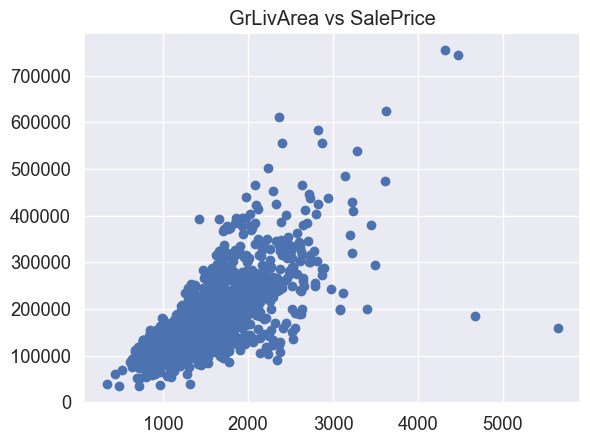

In [46]:
plt.scatter(train_df["GrLivArea"], train_df["SalePrice"])
plt.title("GrLivArea vs SalePrice")

# Analiza numeričkih i kategorijskih varijabli

In [47]:
numeric_cols = train_df.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = train_df.select_dtypes(include=["object"]).columns

print("Broj numeričkih:", len(numeric_cols))
print("Broj kategorijskih:", len(categorical_cols))

train_df[categorical_cols].nunique().sort_values()

Broj numeričkih: 38
Broj kategorijskih: 43


Street            2
Alley             2
Utilities         2
CentralAir        2
MasVnrType        3
LandSlope         3
PavedDrive        3
GarageFinish      3
PoolQC            3
ExterQual         4
BsmtQual          4
BsmtExposure      4
BsmtCond          4
KitchenQual       4
LandContour       4
LotShape          4
Fence             4
MiscFeature       4
ExterCond         5
Electrical        5
HeatingQC         5
BldgType          5
MSZoning          5
LotConfig         5
GarageQual        5
GarageCond        5
FireplaceQu       5
Heating           6
BsmtFinType1      6
BsmtFinType2      6
RoofStyle         6
Foundation        6
GarageType        6
SaleCondition     6
Functional        7
HouseStyle        8
RoofMatl          8
Condition2        8
SaleType          9
Condition1        9
Exterior1st      15
Exterior2nd      16
Neighborhood     25
dtype: int64

# Korelacija s ciljnim atributom (SalePrice)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64


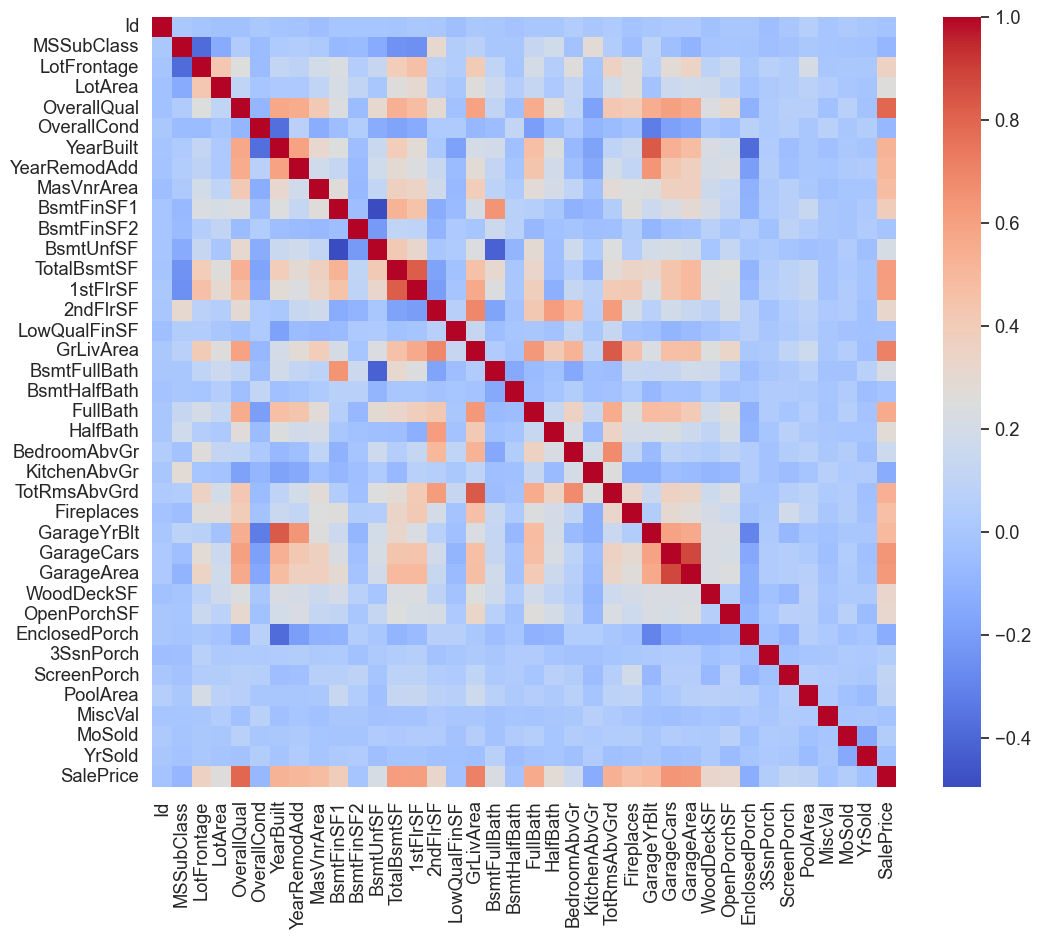

In [48]:
correlation = train_df[numeric_cols].corr()["SalePrice"].sort_values(ascending=False)
correlation.head(15)

# Vizualna korelacija (heatmap)
plt.figure(figsize=(12,10))
sns.heatmap(train_df[numeric_cols].corr(), cmap="coolwarm", annot=False)

correlation = train_df.corr(numeric_only=True)["SalePrice"].sort_values(ascending=False)
print(correlation.head(15))


# Analiza ciljne varijable SalePrice

Text(0.5, 1.0, 'Distribucija SalePrice')

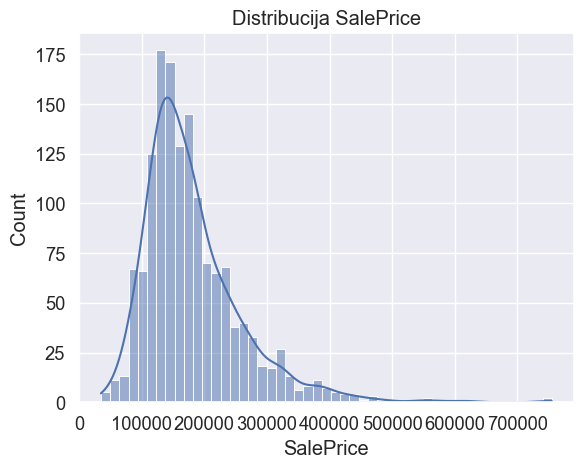

In [49]:
sns.histplot(train_df["SalePrice"], kde=True)
plt.title("Distribucija SalePrice")

# Unique vrijednosti za kategorijske kolone

In [50]:
train_df[categorical_cols].nunique().sort_values()

Street            2
Alley             2
Utilities         2
CentralAir        2
MasVnrType        3
LandSlope         3
PavedDrive        3
GarageFinish      3
PoolQC            3
ExterQual         4
BsmtQual          4
BsmtExposure      4
BsmtCond          4
KitchenQual       4
LandContour       4
LotShape          4
Fence             4
MiscFeature       4
ExterCond         5
Electrical        5
HeatingQC         5
BldgType          5
MSZoning          5
LotConfig         5
GarageQual        5
GarageCond        5
FireplaceQu       5
Heating           6
BsmtFinType1      6
BsmtFinType2      6
RoofStyle         6
Foundation        6
GarageType        6
SaleCondition     6
Functional        7
HouseStyle        8
RoofMatl          8
Condition2        8
SaleType          9
Condition1        9
Exterior1st      15
Exterior2nd      16
Neighborhood     25
dtype: int64

# Statistički rezime SalePrice i ključnih varijabli

In [51]:
train_df["SalePrice"].describe()
train_df[["OverallQual", "GrLivArea", "GarageCars", "TotalBsmtSF"]].describe()

train_df[numeric_cols].skew().sort_values(ascending=False).head(10)

MiscVal          24.476794
PoolArea         14.828374
LotArea          12.207688
3SsnPorch        10.304342
LowQualFinSF      9.011341
KitchenAbvGr      4.488397
BsmtFinSF2        4.255261
ScreenPorch       4.122214
BsmtHalfBath      4.103403
EnclosedPorch     3.089872
dtype: float64

# Analiza najjače koreliranih feature-a sa SalePrice

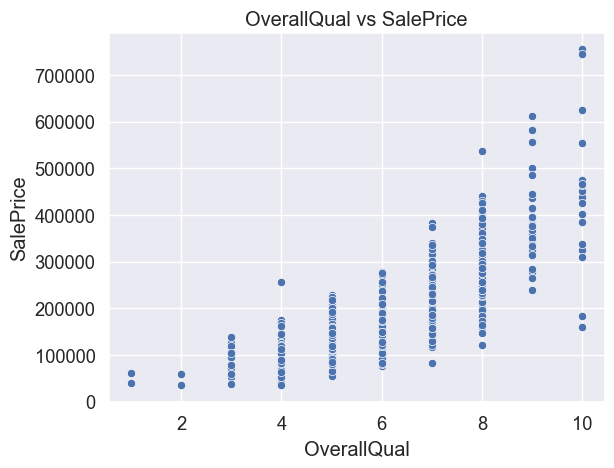

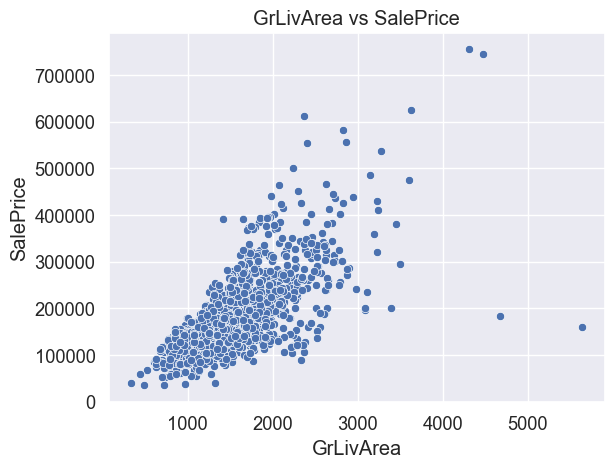

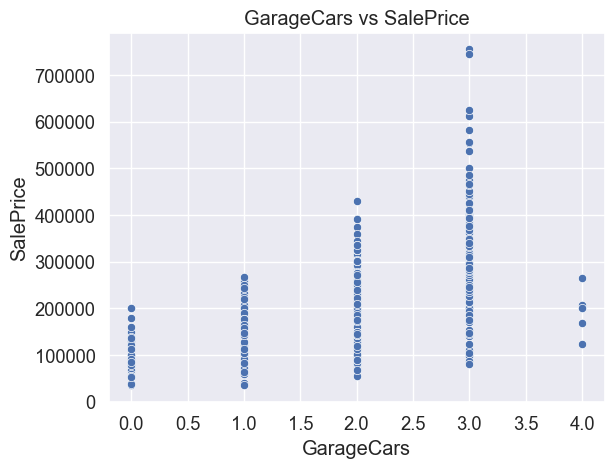

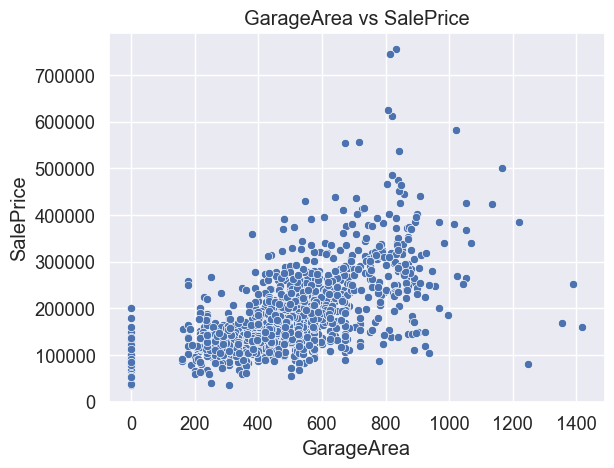

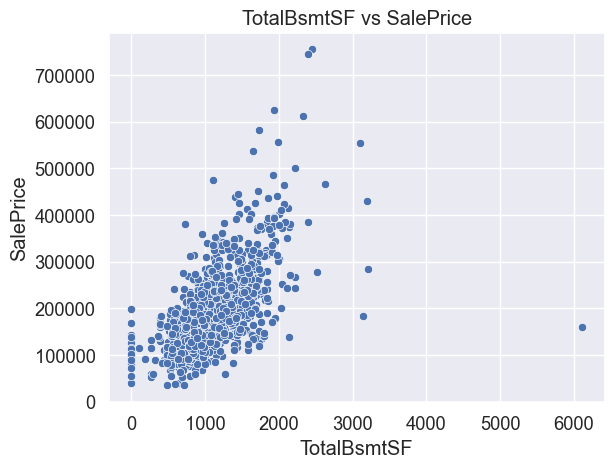

In [52]:
top_corr = correlation[1:6].index
for col in top_corr:
    sns.scatterplot(x=train_df[col], y=train_df["SalePrice"])
    plt.title(f"{col} vs SalePrice")
    plt.show()

# Višedimenzionalna analiza ključnih feature-a

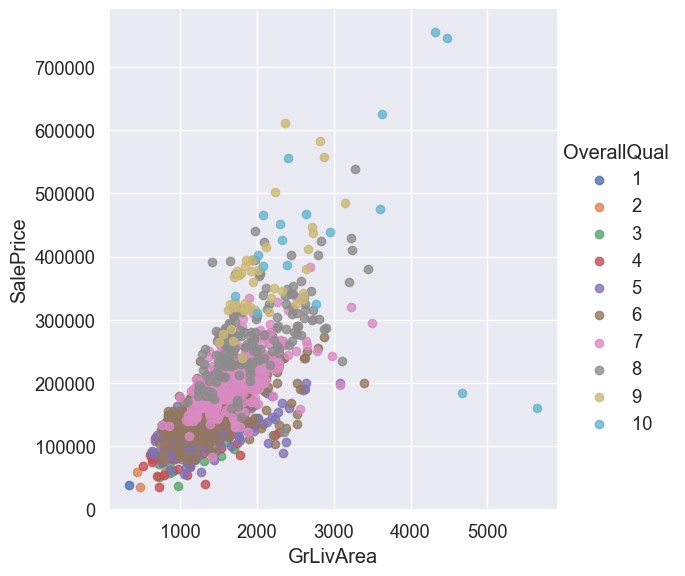

In [53]:
sns.lmplot(data=train_df, x="GrLivArea", y="SalePrice", hue="OverallQual", fit_reg=False, height=6)

# Boxplot za SalePrice vs Kategorijske varijable

Text(0.5, 1.0, 'Cijena po naselju')

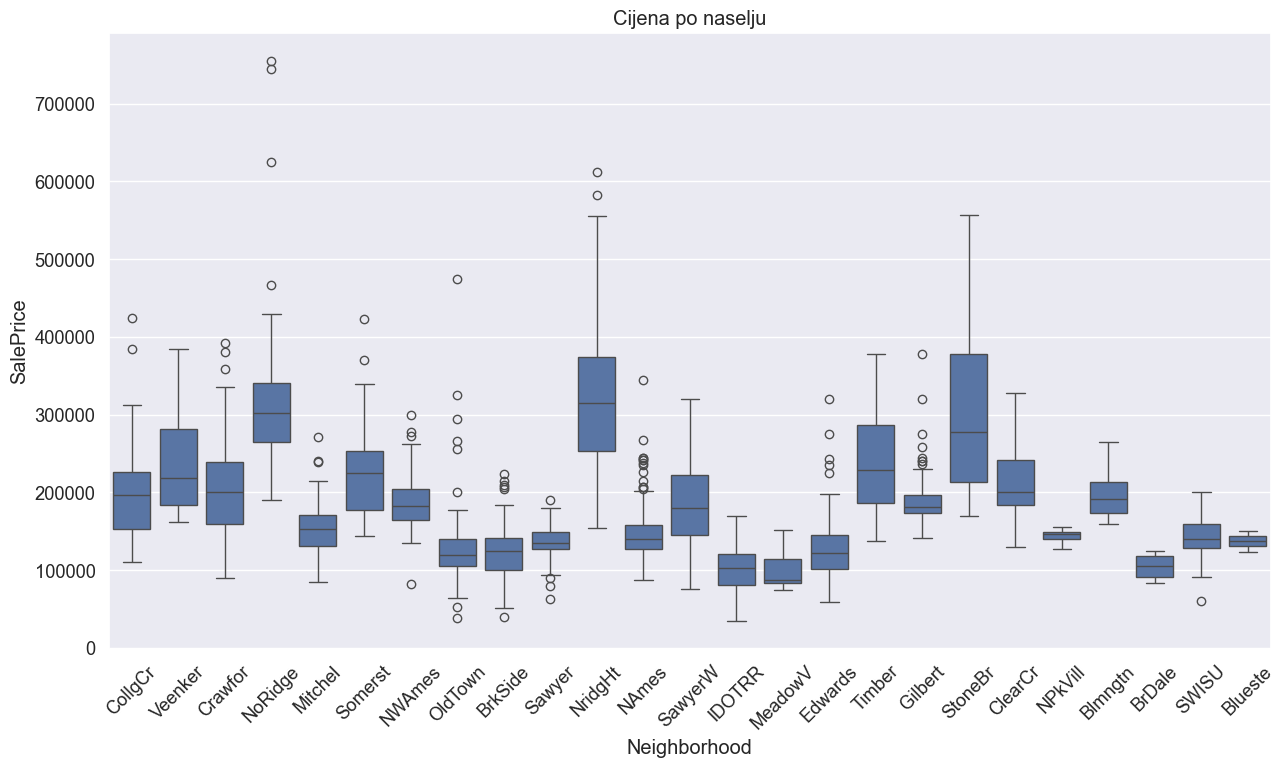

In [54]:
plt.figure(figsize=(15,8))
sns.boxplot(x="Neighborhood", y="SalePrice", data=train_df)
plt.xticks(rotation=45)
plt.title("Cijena po naselju")

# Provjera duplikata

In [55]:
train_df.duplicated().sum()

np.int64(0)

# Provjera kolona sa niskim varijacijama (low variance)

In [56]:
low_variance = [col for col in train_df.columns if train_df[col].nunique() < 3]
print("Kolone sa skoro istim vrijednostima:", low_variance)

Kolone sa skoro istim vrijednostima: ['Street', 'Alley', 'Utilities', 'CentralAir']


# Vizualna analiza odnosa varijabli (pairplot)

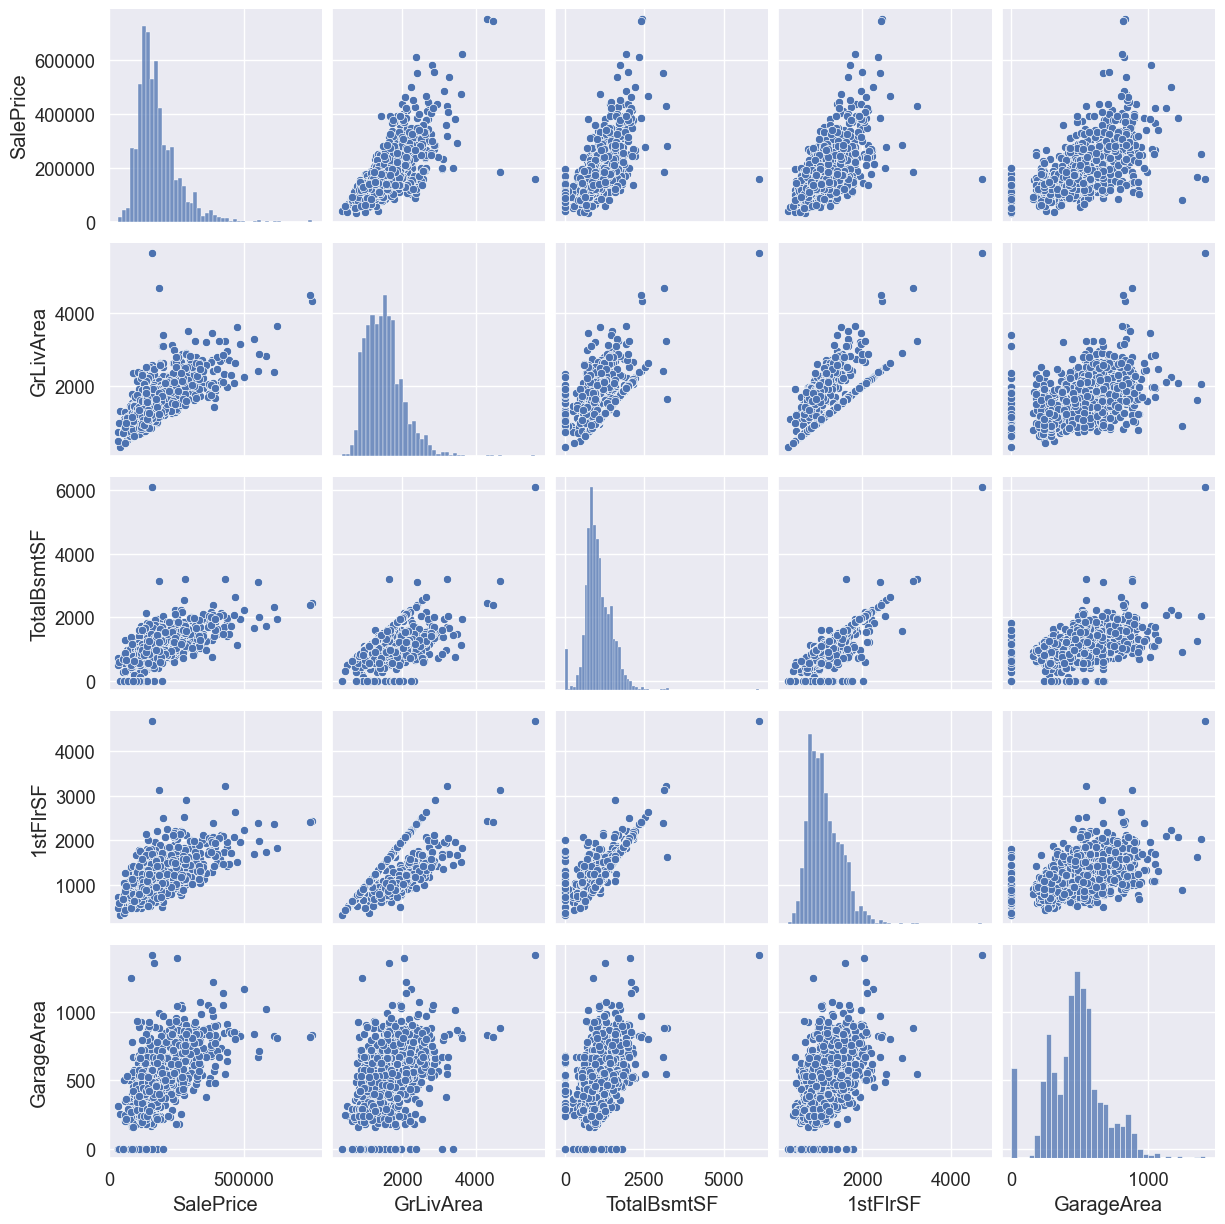

In [57]:
sns.pairplot(train_df[["SalePrice", "GrLivArea", "TotalBsmtSF", "1stFlrSF", "GarageArea"]])

# Kolone sa NaN vrijednostima

Text(0.5, 1.0, 'Kolone sa najvećim postotkom NaN vrijednosti')

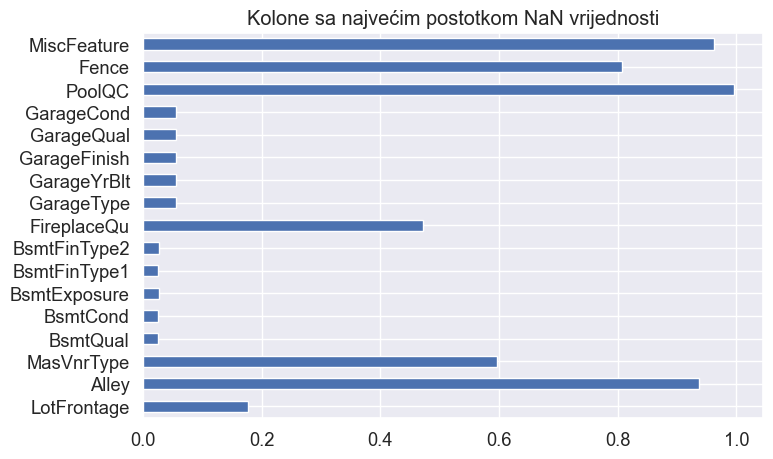

In [58]:
col_nan = train_df.isna().sum() / train_df.shape[0]

plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
col_nan[col_nan > 0.01].plot(kind = "barh")
plt.title("Kolone sa najvećim postotkom NaN vrijednosti")

# Čišćenje podataka

# Uklanjanje ID kolona

In [59]:
train_df = train_df.drop("Id", axis=1)
test_df = test_df.drop("Id", axis=1)

# Uklanjanje kolona sa istim vrijednostima

In [60]:
train_df = train_df.drop(["Street", "Utilities"], axis=1)
test_df = test_df.drop(["Street", "Utilities"], axis=1)

# Uklanjanje outliera

In [61]:
train_df = train_df.drop(train_df[(train_df['GrLivArea'] > 4500)].index)

# Spajanje train + test u jedan skup radi zajedničke obrade

In [62]:
y = train_df['SalePrice']
train_features = train_df.drop(['SalePrice'], axis=1)
all_data = pd.concat([train_features, test_df]).reset_index(drop=True)

# Ispravljanje grešaka u podacima

In [63]:
all_data.loc[all_data['GarageYrBlt'] > 2017, 'GarageYrBlt'] = 2007

# Popunjavanje LotFrontage po Neighborhood

In [64]:
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# Numeričke koje treba pretvoriti u kategorijske

In [65]:
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

# Z-score metoda za uklanjanje outliera (samo na train_df)

In [66]:
from scipy import stats
import numpy as np

def remove_outliers(dataset, threshold=3, columns=None):
    if columns is None:
        columns = dataset.select_dtypes(include=['int64', 'float64']).columns
    z = np.abs(stats.zscore(dataset[columns]))
    outliers = (z > threshold).any(axis=1)
    print(f"Uklonjeno redova: {outliers.sum()}")
    return dataset[~outliers]

# Primijeni samo na trening skup jer je target poznat
train_df_clean = remove_outliers(train_df, columns=['GrLivArea'])

Uklonjeno redova: 16


# Popunjavanje nedostajućih vrijednosti (numeričke)

In [67]:
from sklearn.impute import SimpleImputer

zero_fill = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']
median_fill = [col for col in all_data.select_dtypes(include=['int64', 'float64']).columns if col not in zero_fill]

all_data[zero_fill] = all_data[zero_fill].fillna(0)
all_data[median_fill] = all_data[median_fill].fillna(all_data[median_fill].median())

# Popunjavanje kategorijskih kolona specifičnim vrijednostima

In [68]:
none_conversion = [
    ("MasVnrType","None"), ("BsmtQual","NA"), ("Electrical", "SBrkr"),
    ("BsmtCond","TA"), ("BsmtExposure","No"), ("BsmtFinType1","No"), ("BsmtFinType2","No"),
    ("FireplaceQu","NA"), ("GarageType","No"), ("GarageFinish","No"),
    ("GarageQual","NA"), ("GarageCond","NA"), ("KitchenQual","TA"),
    ("Functional","Typ"), ("MSZoning", "None"), ("Exterior1st", "VinylSd"),
    ("Exterior2nd", "VinylSd"), ("SaleType", "WD")
]

for col, val in none_conversion:
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna(val)

# Transformacija "skewed" kolona sa Box-Cox

In [69]:
from scipy.special import boxcox1p
from scipy.stats import skew

numeric_feats = all_data.select_dtypes(include=['int64', 'float64']).columns
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
high_skew = skewed_feats[skewed_feats > 0.5].index

for feat in high_skew:
    all_data[feat] = boxcox1p(all_data[feat], 0.15)

# Enkodiranje kategorijskih varijabli za xGBoost i Random Forest

In [70]:
from sklearn.preprocessing import LabelEncoder

def encode_features(df):
    df = df.copy()
    label_encoders = {}

    # 1. Ručno mapiranje ordinalnih varijabli
    ordinal_mappings = {
        "ExterQual": {"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
        "ExterCond": {"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
        "BsmtQual": {"NA":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
        "BsmtCond": {"NA":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
        "HeatingQC": {"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
        "KitchenQual": {"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
        "FireplaceQu": {"NA":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
        "GarageQual": {"NA":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
        "GarageCond": {"NA":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
        "PoolQC": {"NA":0, "Fa":1, "TA":2, "Gd":3, "Ex":4},
        "BsmtExposure": {"NA":0, "No":1, "Mn":2, "Av":3, "Gd":4},
        "BsmtFinType1": {"NA":0, "Unf":1, "LwQ":2, "Rec":3, "BLQ":4, "ALQ":5, "GLQ":6},
        "BsmtFinType2": {"NA":0, "Unf":1, "LwQ":2, "Rec":3, "BLQ":4, "ALQ":5, "GLQ":6},
        "Functional": {"Sal":1, "Sev":2, "Maj2":3, "Maj1":4, "Mod":5, "Min2":6, "Min1":7, "Typ":8},
        "GarageFinish": {"NA":0, "Unf":1, "RFn":2, "Fin":3},
        "Fence": {"NA":0, "MnWw":1, "GdWo":2, "MnPrv":3, "GdPrv":4},
        "LotShape": {"IR3":1, "IR2":2, "IR1":3, "Reg":4},
        "PavedDrive": {"N":0, "P":1, "Y":2},
        "Utilities": {"ELO":1, "NoSeWa":2, "NoSewr":3, "AllPub":4},
        "LandSlope": {"Sev":1, "Mod":2, "Gtl":3}
    }

    for col, mapping in ordinal_mappings.items():
        if col in df.columns:
            df[col] = df[col].map(mapping).fillna(0).astype(int)

    # 2. Label Encoding za ostale kategorijske varijable (koje su object dtype)
    categorical_cols = df.select_dtypes(include=['object']).columns

    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = df[col].astype(str)  # sigurnost ako ima NaN
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le  # čuvamo enkodere za kasnije (npr. test skup)

    return df, label_encoders

In [71]:
all_data_encoded, label_encoders = encode_features(all_data)

In [72]:
X_train = all_data_encoded.iloc[:train_features.shape[0], :].copy()
X_test = all_data_encoded.iloc[train_features.shape[0]:, :].copy()

# Provjera čišćenja

In [73]:
print("X_train shape:", X_train.shape)
print("y shape:", y.shape)
print("X_test shape:", X_test.shape)

X_train shape: (1458, 77)
y shape: (1458,)
X_test shape: (1459, 77)


# Provjera NaN vrijednosti

In [74]:
print("NaN u X_train:", X_train.isnull().sum().sum())
print("NaN u X_test:", X_test.isnull().sum().sum())

NaN u X_train: 0
NaN u X_test: 0


# Provjera tipova podataka

In [75]:
print(X_train.dtypes.value_counts())

int64      50
float64    27
Name: count, dtype: int64


# Provjera distribucije target varijable (y)

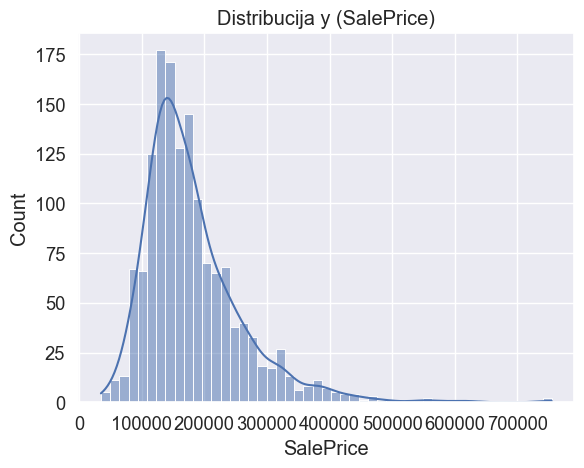

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(y, kde=True)
plt.title("Distribucija y (SalePrice)")
plt.show()

# Provjera korelacija

In [77]:
train_corr = X_train.copy()
train_corr["SalePrice"] = y
correlation = train_corr.corr()["SalePrice"].sort_values(ascending=False)
print(correlation.head(10))

SalePrice      1.000000
OverallQual    0.287047
GrLivArea      0.248560
GarageCars     0.244847
GarageArea     0.243663
ExterQual      0.242166
KitchenQual    0.230058
BsmtQual       0.227074
1stFlrSF       0.218437
FireplaceQu    0.213916
Name: SalePrice, dtype: float64
